# goom tests
Use this notebook to run pytest from the repo root with the `goom_jax` conda env active.

In [1]:
import jax
import jax.numpy as jnp
from jax import lax

import goom.goom as goom
import goom.lmme as lmme
import goom.operations as oprs
import goom.lle as lle

config = goom.config  # grab the config object from the goom module

config.keep_logs_finite = True          # log(0) will return a finite floor
config.cast_all_logs_to_complex = True  # GOOMs are complex-typed
config.float_dtype = jnp.float32        # real dtype



%load_ext autoreload
%autoreload 2




In [2]:
# --- Make a chain of matrices: shape (T, N, N) ------------------------
T, N = 10_000, 20
key = jax.random.PRNGKey(0)
mats = 20*jax.random.normal(key, (T, N, N), dtype=config.float_dtype)/(jnp.sqrt(N))


# --- 1. Parallel product over *float* tensors (usually blows up) ------
def matmul_op(a, b):
    # a, b: (..., N, N)
    return a @ b

# lax.associative_scan does a parallel prefix of an associative op
float_prefix_products = lax.associative_scan(matmul_op, mats, axis=0)

# Final product of the whole chain:
float_prod = float_prefix_products[-1]

print("Computes over float tensors?",
      bool(jnp.isfinite(float_prod).all()))


# --- 2. Parallel product over GOOMs -----------------------------------
# Turn each matrix into its GOOM "log" representation
log_mats = goom.to_goom(mats)   # shape (T, N, N), complex dtype


# Parallel scan with the GOOM matmul log kernel
log_prefix_products = lax.associative_scan(lmme.log_matmul_exp, log_mats, axis=0)

# Final log-product of the whole chain in GOOM space:
log_prod = log_prefix_products[-1]

# Map back from GOOMs to (approximate) real-space product
prod_goom = goom.from_goom(log_prod)

print("Computes over complex GOOMs?",
      bool(jnp.isfinite(log_prod).all()))


Computes over float tensors? False
Computes over complex GOOMs? True


In [3]:
# compare LLE computed in paralle to sequential algorithm
lle_est_par = lle.jax_estimate_lle_parallel(mats, key, dt=1.0)
lle_est_seq = lle.jax_estimate_lle_sequential(mats, key, dt=1.0)

print("Parallel LLE vs Sequential LLE Close?:",
      bool(jnp.isclose(lle_est_par, lle_est_seq, atol=1e-3, rtol=1e-3)))

Parallel LLE vs Sequential LLE Close?: True


In [22]:


dt = 1e-3  # time step


def lorenz(x, sigma=10.0, rho=28.0, beta=8.0 / 3.0):
    """Lorenz vector field: dx/dt = f(x)."""
    x_, y_, z_ = x
    dx = sigma * (y_ - x_)
    dy = x_ * (rho - z_) - y_
    dz = x_ * y_ - beta * z_
    return jnp.array([dx, dy, dz])


def euler_step(x, dt=dt, sigma=10.0, rho=28.0, beta=8.0 / 3.0):
    """One Euler step for the Lorenz system: x_{n+1} = x_n + dt * f(x_n)."""
    return x + dt * lorenz(x, sigma=sigma, rho=rho, beta=beta)


def simulate_lorenz_with_jacobians(
    x0,
    T,
    dt=dt,
    sigma=10.0,
    rho=28.0,
    beta=8.0 / 3.0,
):
    """
    Simulate T steps of Lorenz and return states and Jacobians.

    Args:
        x0: shape (3,) initial state.
        T:  number of time steps (int).
        dt, sigma, rho, beta: integration and Lorenz parameters.

    Returns:
        states:    shape (T+1, 3), states from t=0..T
        jacobians: shape (T, 3, 3), J_t = d x_{t+1} / d x_t, for t=0..T-1
    """

    def step_with_jac(x, _):
        # Define a pure function for the step map so we can differentiate it
        def step_fn(x_):
            return euler_step(x_, dt=dt, sigma=sigma, rho=rho, beta=beta)

        x_next = step_fn(x)
        J = jax.jacrev(step_fn)(x)  # 3x3 Jacobian of step map at x
        return x_next, (x_next, J)

    # lax.scan carries the state and accumulates (state, J)
    xT, (xs, Js) = lax.scan(step_with_jac, x0, xs=None, length=T)

    # Prepend the initial state to get states of length T+1
    states = jnp.vstack([x0[None, :], xs])

    return states, Js


# Optionally JIT-compile for speed (T is static)
simulate_lorenz_with_jacobians_jit = jax.jit(
    simulate_lorenz_with_jacobians,
    static_argnames=("T",)
)


In [ ]:
x0 = jnp.array([1.0, 0.0, 1.0])
T = 400_000  # simulate 400K
key = jax.random.PRNGKey(42)

states, jac_vals = simulate_lorenz_with_jacobians_jit(x0, T)

# not giving the correct answers
lle_est_par = lle.jax_estimate_lle_parallel(jac_vals, key, dt=dt)
lle_est_seq = lle.jax_estimate_lle_sequential(jac_vals, key, dt=dt)

print(f"{lle_est_par:.4f}")
print(f"{lle_est_seq:.4f}")

0.9089
0.9069


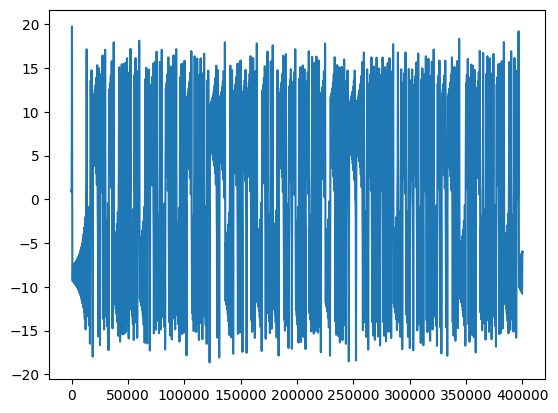

In [24]:
import matplotlib.pyplot as plt
plt.plot(states[:,0])